In [5]:
%config Completer.use_jedi = False

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms

import numpy as np
import matplotlib.pyplot as plt

In [40]:
train_transforms = transforms.Compose([
    transforms.Resize((300, 400)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(300, 400),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [41]:
train_data = datasets.ImageFolder(root="data/train", transform=train_transforms)
valid_data = datasets.ImageFolder(root="data/train", transform=valid_transforms)

In [48]:
len(train_data.classes)

12

In [42]:
num_train = len(train_data)
indices = list(range(len(train_data)))
split = int(np.floor(0.1 * len(train_data)))

In [43]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [46]:
train_loader = DataLoader(train_data, batch_size=4, sampler=train_sampler)
valid_loader = DataLoader(valid_data, batch_size=4, sampler=valid_sampler)

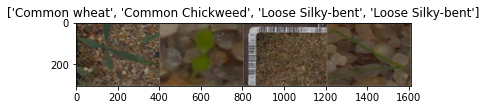

In [47]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_data.classes[x] for x in classes])

In [53]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 12)
model = model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [55]:
for epoch in range(20):
    print(f"Epoch {epoch}/19 ")
    for inputs, labels in train_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Epoch 0/19 


KeyboardInterrupt: 